In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [106]:
import os
import glob
import sys
import pandas as pd
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
import ipv_workbench
from ipv_workbench.translators import panelizer
from ipv_workbench.utilities import utils, time_utils
from ipv_workbench.translators import mapping_irradiance as ipv_irrad
from ipv_workbench.translators import module_mapping as ipv_mm
from ipv_workbench.translators import results_writers as ipv_results
from ipv_workbench.sample import dummies
from ipv_workbench.solver import calculations as ipv_calc
from ipv_workbench.solver import simulations_mp as ipv_sim_mp
from ipv_workbench.solver import compile_mp
from ipv_workbench.solver import single_module_mp
from ipv_workbench.solver import topology_solver as ipv_ts
from ipv_workbench.visualize import plots as ipv_plots
from ipv_workbench.devices import devices
from ipv_workbench.workflows import bano_workflow
import pickle
from pprint import pprint
import numpy as np
import pvlib
import matplotlib.pyplot as plt
import random
import sympy
import copy
import proplot as pplt
from pathlib import Path
import openpyxl

In [133]:
bano_workflow.main()

Setting dict from raw panelizer file
    Starting micro_inverter
    Starting string_inverter
    Starting central_inverter
3384.26602522158 17940.0
3059.3782215743863 17940.0
1616.498358708498 17940.0
Setting dict from raw panelizer file
/Users/jmccarty/Desktop/bano_simulations/objects/B1391/panelizer/AP_light_grey_B1391_raw.pickle
Input detected as string but file path does not exist.


AttributeError: 'PanelizedObject' object has no attribute 'panelizer_dict'

# Initial Panelizer for Building/Scenario

In [ ]:
project_folder = "/Users/jmccarty/Desktop/bano_simulations"
year_list = [2020,2050,2080]
building_list = ["B1360","B1389","B1390","B1391","B1392","B1394","B2494"]

for year in year_list: 
    for building in building_list:
        for cell_technology in ["A","B","C","D","E"]:
            for orientation in ["P","L"]:
                for front_cover in ["solar_glass", "light_grey", "basic_white"]:
                    scenario = f"{cell_technology}{orientation}_{front_cover}_{year}"
                    raw_panelizer_file = f"{cell_technology}{orientation}_{front_cover}_{building}_raw.pickle"
                    panelizer_object = panelizer.PanelizedObject(project_folder, building, raw_panelizer_file)
                    panelizer_object.analysis_location = 'zurich'
                    panelizer_object.analysis_year = year
                    panelizer_object.set_tmy_data()
                    panelizer_object.set_analysis_period(0,8760,1)
                    custom_device_data = pd.read_csv(panelizer_object.module_cell_data, index_col='scenario').loc[
                        f"{cell_technology}{orientation}"].to_dict()
                    panelizer_object.cell = devices.Cell(custom_device_data)

In [5]:
PROJECT_FOLDER = "/Users/jmccarty/Desktop/bano_simulations"
BUILDING ="B1391"
CELLTECHNOLOGY = "A" #A,mono B,poly, C,cdte, D,cigs, E,asi
ORIENTATION = "P" #P=portrait, L=Landscape
FRONTCOVER = "solar_glass" #solar_glass, light_grey, basic_white
YEAR = 2020

scenario = f"{CELLTECHNOLOGY}{ORIENTATION}_{FRONTCOVER}_{YEAR}"
raw_panelizer_file = f"{CELLTECHNOLOGY}{ORIENTATION}_{FRONTCOVER}_{BUILDING}_raw.pickle"
completed_panelizer_file = f"{CELLTECHNOLOGY}{ORIENTATION}_{FRONTCOVER}_{BUILDING}_completed.pickle"

pickle_in = os.path.join(PROJECT_FOLDER,"panelizer",BUILDING,raw_panelizer_file)
pickle_out = os.path.join(PROJECT_FOLDER,"systems",BUILDING,raw_panelizer_file)
po = panelizer.PanelizedObject(PROJECT_FOLDER, BUILDING, raw_panelizer_file)
po.analysis_location = 'zurich'
po.analysis_year = YEAR
po.set_tmy_data()

po.set_analysis_period(0,8760,1)
# file_p = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/devices/default_devices/cell_parameters_default_monocrystalline.txt"
custom_device_data = pd.read_csv(po.module_cell_data, index_col='scenario').loc[f"{CELLTECHNOLOGY}{ORIENTATION}"].to_dict()
po.cell = devices.Cell(custom_device_data)


Setting dict from raw panelizer file


# Solve Module IV Curves

In [6]:
%%capture
panelizer.solve_object_module_iv(po, mp=True)

# Write

In [7]:

# TODO this is doing some work that is repeated
po.transfer_initial()

In [8]:
for surface in po.get_surfaces():
    for topology in po.simulation_suite_topologies: 
        po.topology = topology
        if topology=='micro_inverter':
            for string in po.get_strings(surface):
                po.write_first_level_results(surface, string)
        else:
            po.write_first_level_results(surface)

/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/solver/simulations.py:220: RuntimeWarning: invalid value encountered in divide
  Pv = dP / dV  # size is (2, 1)
/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/solver/simulations.py:220: RuntimeWarning: divide by zero encountered in divide
  Pv = dP / dV  # size is (2, 1)


In [9]:
extra_keys = ["actual_module_area_m2", 'actual_capacity_Wp']

for topology in po.simulation_suite_topologies:
    print(f"    Starting {topology}")
    po.topology = topology
    for surface in po.get_surfaces():
        
        if po.topology=='micro_inverter':
            for string in po.get_strings(surface):
                po.write_up_string_results(surface, string)

        po.write_up_surface_results(surface)

    po.write_up_object_results()
    
po.write_key_parameters()

    Starting micro_inverter
    Starting string_inverter
    Starting central_inverter


# Results

## Building Level

In [66]:
df = ipv_results.write_building_results_timeseries(po, scenario, topology)

## Cumulative

In [68]:
building_results_files = [df] * 3

In [79]:
bldg_df_a = pd.DataFrame(results_dict).set_index("index")
bldg_df_b = pd.DataFrame(results_dict).set_index("index")
bldg_df_c = pd.DataFrame(results_dict).set_index("index")

bldg_results = [bldg_df_a, bldg_df_b, bldg_df_c]
bldg_results[0]

,electricity_gen_bulk_building_kwh,self_sufficiency_building_percent,self_consumption_building_percent,electricity_specific_yield_building_kwh_kwp,electricity_gen_intensity_building_kwh,surface_capacity_1391_0_8_north_kwp,surface_area_1391_0_8_north_m2,electricity_gen_bulk_1391_0_8_north_kwh,electricity_specific_yield_1391_0_8_north_kwh_kwp,electricity_gen_intensity_1391_0_8_north_kwh_m2,...,surface_capacity_1391_0_11_west_kwp,surface_area_1391_0_11_west_m2,electricity_gen_bulk_1391_0_11_west_kwh,electricity_specific_yield_1391_0_11_west_kwh_kwp,electricity_gen_intensity_1391_0_11_west_kwh_m2,efficiency_1391_0_11_west_yield_irrad,irrad_bulk_1391_0_11_west_kWh,irrad_intensity_1391_0_11_west_kWh_m2,self_sufficiency_1391_0_11_west_percent,self_consumption_1391_0_11_west_percent
index,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.224,1.54,0.0,0.0,0.0,...,11.829333,81.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
cumulative_df = ipv_results.write_cumulative_scenario_results(po, scenario, topology, bldg_results)

## Excel Write

In [80]:
object_detail_dicts = [po.get_dict_instance([])['DETAILS']] * 3
object_yield_dicts = [po.get_dict_instance([])['YIELD']] * 3

In [100]:
ipv_results.write_condensed_result(PROJECT_FOLDER, object_detail_dicts, object_yield_dicts, cumulative_df, scenario, topology)

37809121.56566135 427064519.70000005


In [97]:
np.sum([np.sum(np.fromiter(object_dict_yield['micro_inverter']['pmp'].values(), dtype=float)) for object_dict_yield in object_yield_dicts])

81340204.88653241

In [98]:
np.sum([np.sum(np.fromiter(object_dict_yield['micro_inverter']['irrad'].values(), dtype=float)) for object_dict_yield in object_yield_dicts])

427064519.70000005

In [96]:
po.get_dict_instance([])['YIELD']['central_inverter']['irrad']

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 3161.8999999999996,
 9: 14778.100000000002,
 10: 16537.8,
 11: 21616.5,
 12: 30262.999999999996,
 13: 25577.9,
 14: 10149.199999999999,
 15: 2664.9,
 16: 444.69999999999993,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 2300.2999999999997,
 33: 6128.6,
 34: 7791.5999999999985,
 35: 9459.2,
 36: 12587.199999999999,
 37: 13207.900000000001,
 38: 7674.1,
 39: 2931.3,
 40: 334.8,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 4254.7,
 57: 20424.600000000002,
 58: 21660.5,
 59: 26682.7,
 60: 36105.4,
 61: 30409.800000000003,
 62: 11530.0,
 63: 3093.5999999999995,
 64: 555.6,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,


In [95]:
po.get_dict_instance([])['YIELD']['central_inverter']['pmp']

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 233.05901952932953,
 9: 1383.4393391791684,
 10: 1731.7475106043491,
 11: 1666.6580569710463,
 12: 2626.4253593713634,
 13: 2784.586059762012,
 14: 916.126477265457,
 15: 191.50029020616662,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 152.931614052673,
 33: 495.9737133450668,
 34: 697.8591679197971,
 35: 799.7280754193371,
 36: 1095.3845720081954,
 37: 1259.7251021332281,
 38: 673.7253199049885,
 39: 236.21847318104116,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 311.2367191060496,
 57: 1980.9405283949754,
 58: 2327.808493524174,
 59: 2028.7826976474812,
 60: 3159.6792304405226,
 61: 3299.287700897208,
 62: 1030.5043968261584,
 63: 227.0785768299348,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,

# Cold Storage

In [63]:
# utils.write_pickle(po, os.path.join(po.OBJECT_DIR,'cold_storage',f"{scenario}_{po.object_name}_simulation.pickle"), compress=True)

KeyboardInterrupt: 

# Plots

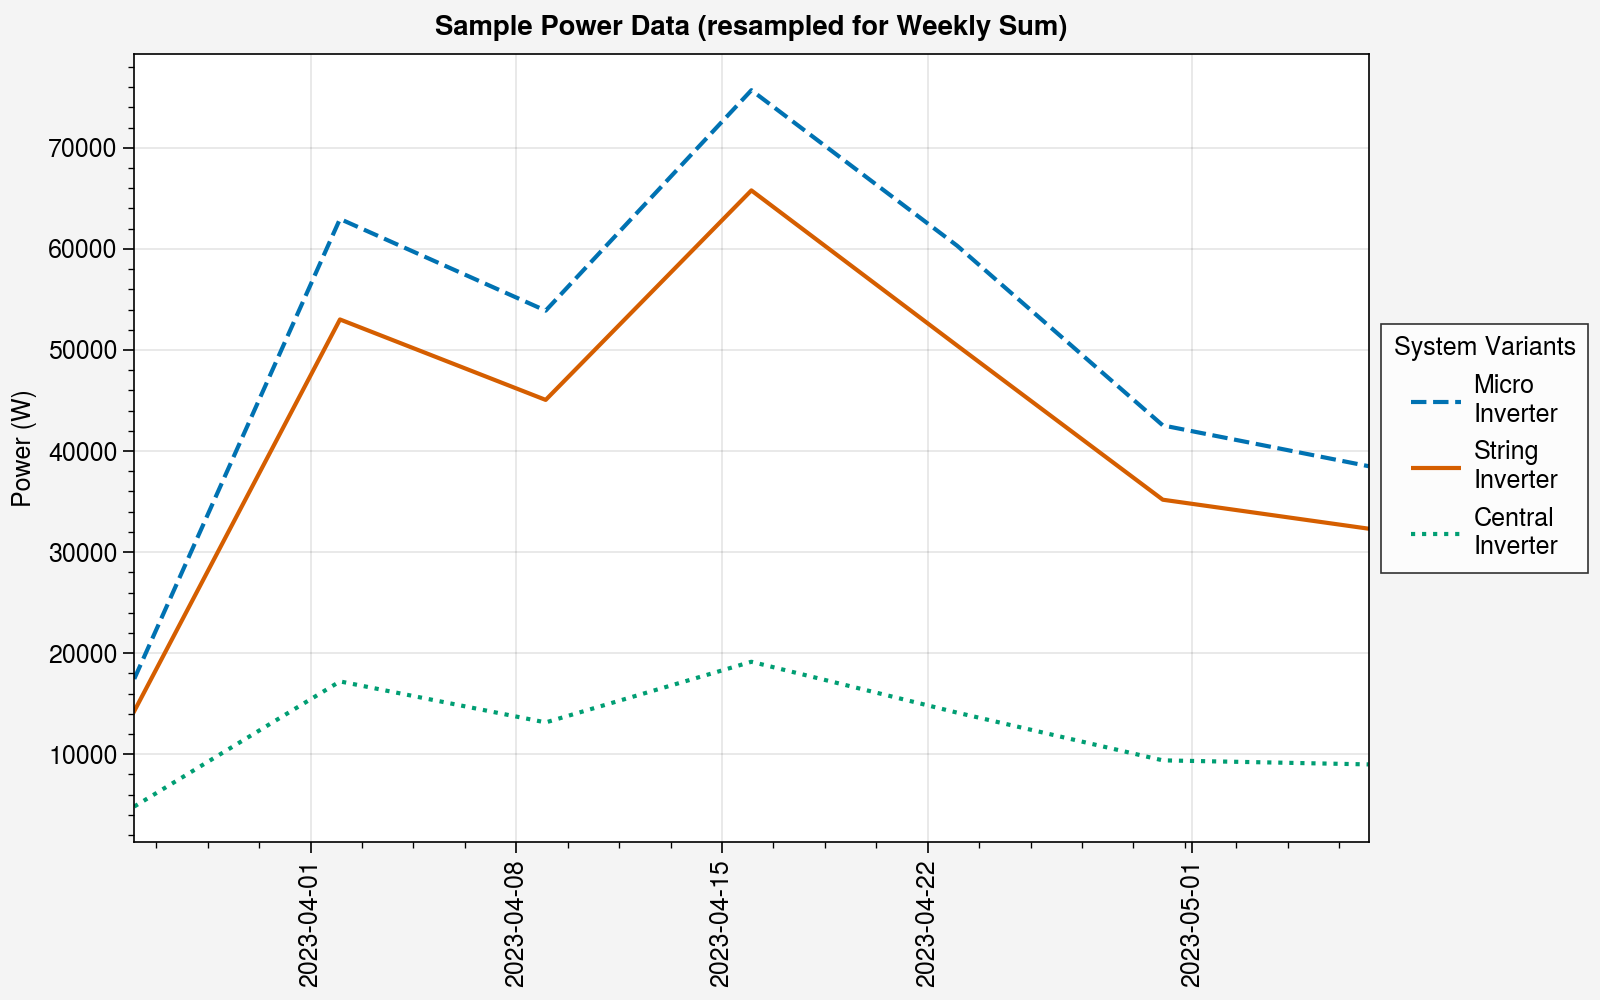

In [20]:
surface = "{1391;0;10}"
string = "{1391;0;10;8}"
module = po.get_modules(surface,string)[0]


# fig, axe = pplt.subplots(ncols=2, nrows=1)

topo = 'micro_inverter'
a = po.get_tabular_results([surface,string],topology=topo,
                      analysis_period=None, rename_cols=False)[['pmp']].resample('W').sum()


topo = 'string_inverter'
b = po.get_tabular_results([surface,string],topology=topo,
                      analysis_period=None, rename_cols=False)[['pmp']].resample('W').sum()

topo = 'central_inverter'
c = po.get_tabular_results([surface,string],topology=topo,
                      analysis_period=None, rename_cols=False)[['pmp']].resample('W').sum()


fig,axes = pplt.subplots(ncols=1,nrows=1,figsize=(8,5))

ax = axes[0]

ax.line(a, linestyle='dashed', label='Micro\nInverter')
ax.line(b, linestyle='solid', label='String\nInverter')
ax.line(c, linestyle='dotted', label='Central\nInverter')
# ax.line(d, linestyle='dashdot', label='string_3')


ax.legend(loc="right", ncols=1, title='System Variants')
ax.format(ylabel='Power (W)',
          suptitle='Sample Power Data (resampled for Weekly Sum)')

# Plot

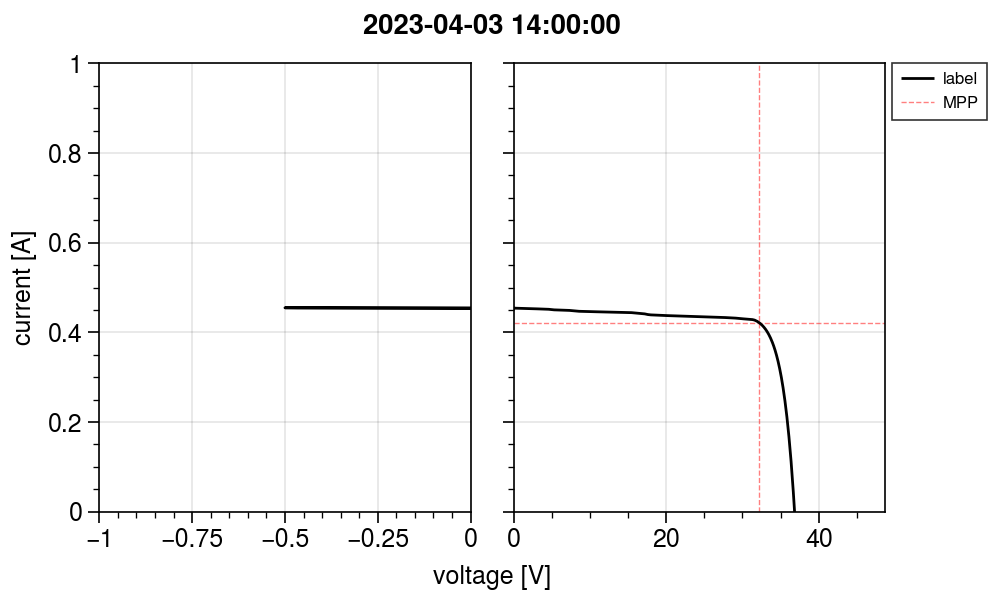

In [127]:
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[1]
module = po.get_modules(surface, string)[0]
string_details = po.get_dict_instance([surface,string])['DETAILS']
curve_dict = po.get_dict_instance([surface,string,module])['CURVES']['initial_simulation']

hoy = 2222

base_parameters = utils.get_cec_data(string_details['cec_key'], file_path=po.CEC_DATA)


ipv_plots.plot_curves(curve_dict['Imod'][hoy],
                      curve_dict['Vmod'][hoy],
                      base_parameters,
                      y_max=1,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                    #   labels=f"{Gmod / 1000} kWh",
                      title=time_utils.hoy_to_date(hoy))

In [ ]:
surface_dict = po.get_dict_instance([surface])

surface_strings_dict = po.get_dict_instance([surface])['STRINGS']

k = []
for key in surface_dict.keys():
    key_result = utils.gather_sublevel_results(po,
                                                surface_strings_dict,
                                                po.get_strings(surface),
                                                key)
    k.append(key_result)

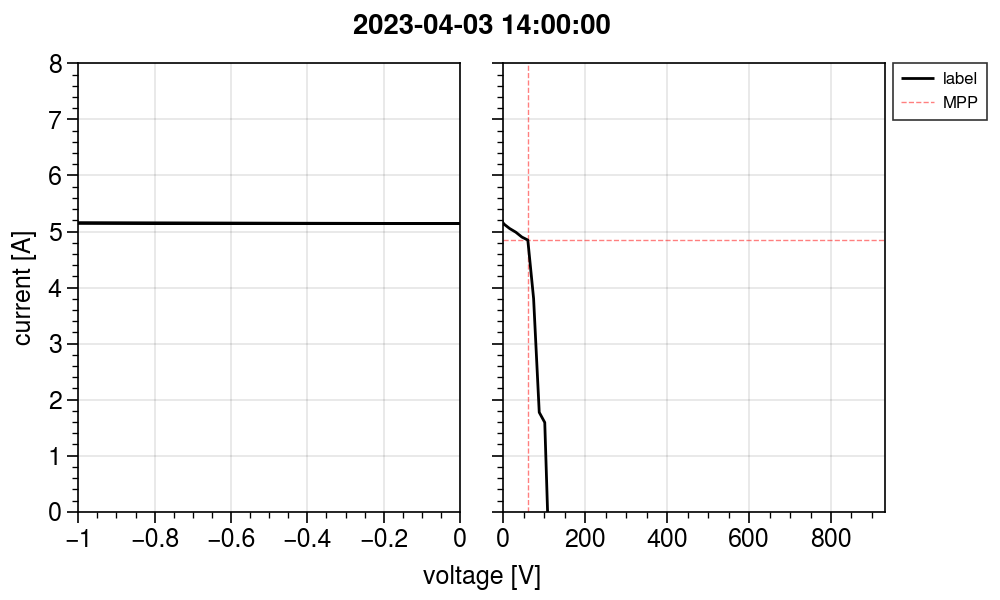

In [137]:
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[1]
module = po.get_modules(surface, string)[0]
string_details = po.get_dict_instance([surface,string])['DETAILS']
curve_dict = po.get_dict_instance([surface])['CURVES']['central_inverter']

hoy = 2222

base_parameters = utils.get_cec_data(string_details['cec_key'], file_path=po.CEC_DATA)


ipv_plots.plot_curves(curve_dict['Isrf'][hoy],
                      curve_dict['Vsrf'][hoy],
                      base_parameters,
                      y_max=8,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                    #   labels=f"{Gmod / 1000} kWh",
                      title=time_utils.hoy_to_date(hoy))

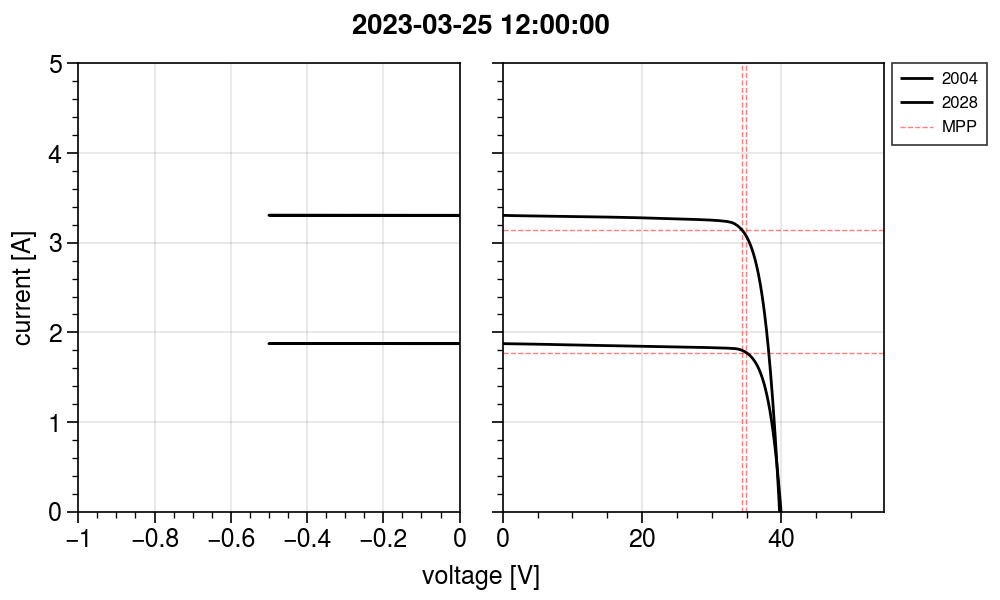

In [170]:
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[1]
module = po.get_modules(surface, string)[0]
string_details = po.get_dict_instance([surface,string])['DETAILS']
curve_dict = po.get_dict_instance([surface,string,module])['CURVES']['micro_inverter']

hoy = 2004

base_parameters = utils.get_cec_data(string_details['cec_key'], file_path=po.CEC_DATA)


ipv_plots.plot_curves([curve_dict['Imod'][2004],curve_dict['Imod'][2028]],
                      [curve_dict['Vmod'][2004],curve_dict['Vmod'][2028]],
                      base_parameters,
                      y_max=5,
                      labels=[2004,2028],
                      mpp=True,
                      x_min=-1,
                    #   labels=f"{Gmod / 1000} kWh",
                      title=time_utils.hoy_to_date(hoy))

In [163]:
po.get_dict_instance([surface,string,module])['YIELD']['micro_inverter']['pmp'][2028]

107.90335733161533

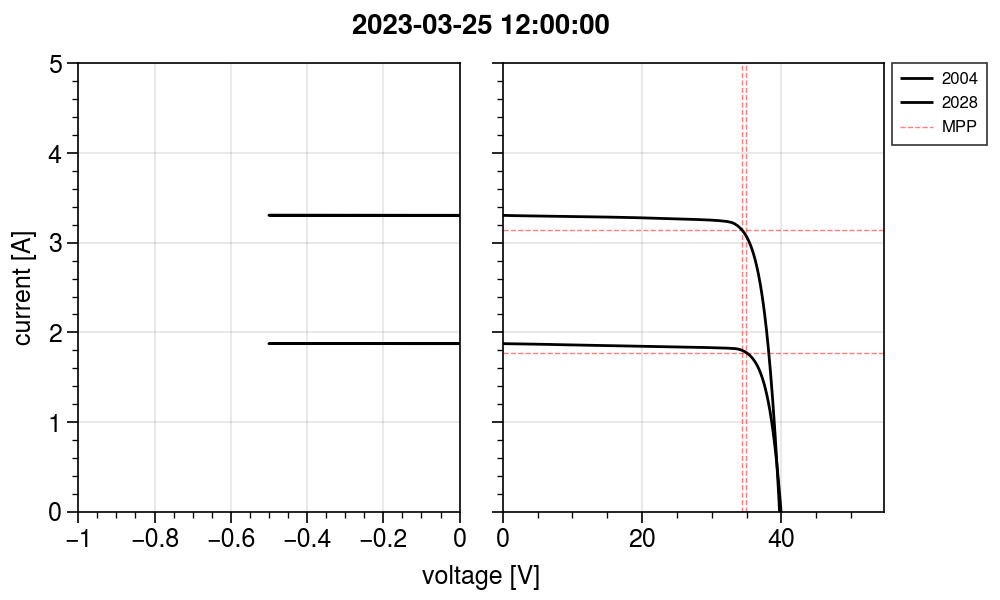

In [169]:
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[1]
module = po.get_modules(surface, string)[0]
string_details = po.get_dict_instance([surface,string])['DETAILS']
curve_dict = po.get_dict_instance([surface,string,module])['CURVES']['string_inverter']

hoy = 2004

base_parameters = utils.get_cec_data(string_details['cec_key'], file_path=po.CEC_DATA)


ipv_plots.plot_curves([curve_dict['Imod'][2004],curve_dict['Imod'][2028]],
                      [curve_dict['Vmod'][2004],curve_dict['Vmod'][2028]],
                      base_parameters,
                      y_max=5,
                      labels=[2004,2028],
                      mpp=True,
                      x_min=-1,
                    #   labels=f"{Gmod / 1000} kWh",
                      title=time_utils.hoy_to_date(hoy))